# Medical Imaging Preprocessing

> A walk-through tutorial how to process, manipulate, and save medical images. 
- toc: true
- use_math: true
- comments: true
- use_plotly: true

- read dicom
- metadata
- resampling
- segmentation (by HU)

# Background

In this tutorial, we will review how to process, handle, and save DICOM data. A great resource to access medical imaging data is through the [Cancer Imaging Archive](https://www.cancerimagingarchive.net/collections/). They maintain an archive of medical images across various datasets that are accessible for public download. We will be using scans from the [LIDC-IDRI](https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX) dataset which contains diagnostic and lung cancer screening thoracic computed tomography scans with annotated lesions in XML format. To handle the annotated lessions, researchers have developed the [pylidc](https://pylidc.github.io/tuts/scan.html) for processing the XML files. 

In [1]:
#hide
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom

from pathlib import Path

In [2]:
#hide
PATH = 'data/LIDC-IDRI/'

patients = os.listdir(PATH)
patients.sort()
print(patients.pop(0))
patients

.ipynb_checkpoints


['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011']

In [3]:
#hide
# not all patient sub-folders contain CT scan, sometimes they're RTSTRUCTs 

patient_path = []
for p in patients:
    patient_directory = glob.glob(f"{PATH}/{p}/**/")
    for mod in patient_directory:
        mod_files = glob.glob(f"{mod}/**/**")
        if len(mod_files) > 10: patient_path.append(mod)
patient_path

['data/LIDC-IDRI//LIDC-IDRI-0001/01-01-2000-NA-NA-30178/',
 'data/LIDC-IDRI//LIDC-IDRI-0002/01-01-2000-NA-NA-98329/',
 'data/LIDC-IDRI//LIDC-IDRI-0003/01-01-2000-NA-NA-94866/',
 'data/LIDC-IDRI//LIDC-IDRI-0004/01-01-2000-NA-NA-91780/',
 'data/LIDC-IDRI//LIDC-IDRI-0005/01-01-2000-NA-NA-42125/',
 'data/LIDC-IDRI//LIDC-IDRI-0006/01-01-2000-NA-NA-92500/',
 'data/LIDC-IDRI//LIDC-IDRI-0007/01-01-2000-NA-NA-81781/',
 'data/LIDC-IDRI//LIDC-IDRI-0008/01-01-2000-NA-NA-30141/',
 'data/LIDC-IDRI//LIDC-IDRI-0009/01-01-2000-NA-NA-07045/',
 'data/LIDC-IDRI//LIDC-IDRI-0010/01-01-2000-NA-NA-43375/',
 'data/LIDC-IDRI//LIDC-IDRI-0011/01-01-2000-NA-NA-73568/']

In [4]:
def load_scan(path):
    slices = [pydicom.read_file(f"{s}") for s in glob.glob(f"{path}/**/*.dcm")]
    # sort slices vertically - bottom up
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

In [5]:
scan = load_scan(patient_path[0])
scan[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.227129408140157230270926028555
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.22712

Digital Imaging and Communications in Medicine or DICOM is a standardized file format for medical imaging information and related data. Typically, you will see the raw medical images stored in this format and later processed to an easier to handle format such as [NIfTI](https://radiopaedia.org/articles/nifti-file-format#:~:text=NIfTI%20is%20a%20type%20of,neuroscience%20and%20even%20neuroradiology%20research.) or [Nrrd](http://teem.sourceforge.net/nrrd/format.html). To process our DICOM files, we are using the ```pydicom``` library and have constructed and read a list of ```pydicom.dataset.FileDataset``` objects with our ```scan``` list. This object allows to access any relevant data elements stored in the DICOM file, useful data elements include ```Modality, RescaleIntercept, RescaleSlope, PixelSpacing, SliceThickness,``` and ```ImagePositionPatient```. We'll need these data elements to standardize our scans to the same pixel spacing and covert our pixel values to the Hounsfield scale. It could also be helpful to use these data elements and construct an array of metadata elements to use for training. This is particularly useful in case you want to identify any subtleties between CT manufacturers. The [DICOM library](https://www.dicomlibrary.com/dicom/dicom-tags/) has an exhaustive list of all the data elements and there use. You will also notice the following standardized format for DICOM data elements:
- a tag that identifies the attribute, usually in the format (XXXX,XXXX) with hexadecimal numbers, and may be divided further into DICOM Group Number and DICOM Element Number;
- a DICOM Value Representation (VR) that describes the data type and format of the attribute value.

In [13]:
# ??pydicom.dataset.FileDataset

In [6]:
type(scan[0])

pydicom.dataset.FileDataset

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [8]:
scan_data = get_pixels_hu(scan)
scan_data.shape

(133, 512, 512)

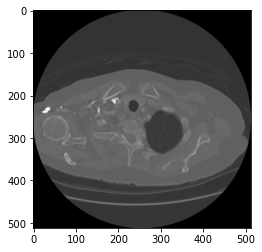

In [10]:
plt.imshow(scan_data[120,...], cmap=plt.cm.gray)